In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')

In [3]:
#Save variable Kyoto_Gases data for the period 2020-2100 (ten-year interval), considering only C1-C8 cases for simplicity.
X_Emissions = Kyoto_Gases.iloc[:,3:-1]
X_Emissions = X_Emissions[X_Emissions['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
X_Emissions.reset_index(drop=True,inplace=True)

In [4]:
#Normalize the data
def normalize_time_series(data):
    return (data - np.mean(data, axis=1).reshape(-1, 1)) / np.std(data, axis=1).reshape(-1, 1)

In [5]:
X_Emissions_Sum = X_Emissions.iloc[:,:-1].values
X_Emissions_normalized = normalize_time_series(X_Emissions_Sum)

In [6]:
from tslearn.metrics import dtw, cdist_dtw
Emissions_distance_matrix = np.load('KyotoGasesMatrix.npy')
#'KyotoGasesMatrix.npy 'saves the previously calculated matrix because it takes a lot of time to repeatedly calculate this matrix. Or you can use cdist_dtw (X_Emissions_normalized) to recalculate.

C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\umap\distances.py:1086: Num

C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


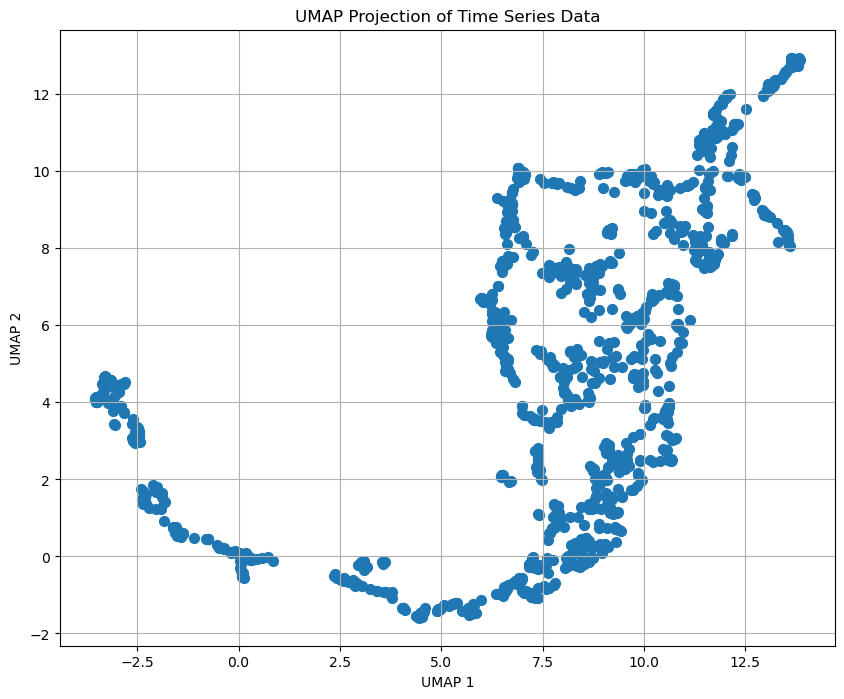

In [7]:
#Dimension reduction is achieved through UMAP method.
import umap
#UMP Embedding
embedding = umap.UMAP(n_neighbors=16, metric='precomputed', random_state=30).fit_transform(Emissions_distance_matrix)
# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=50)
plt.title("UMAP Projection of Time Series Data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

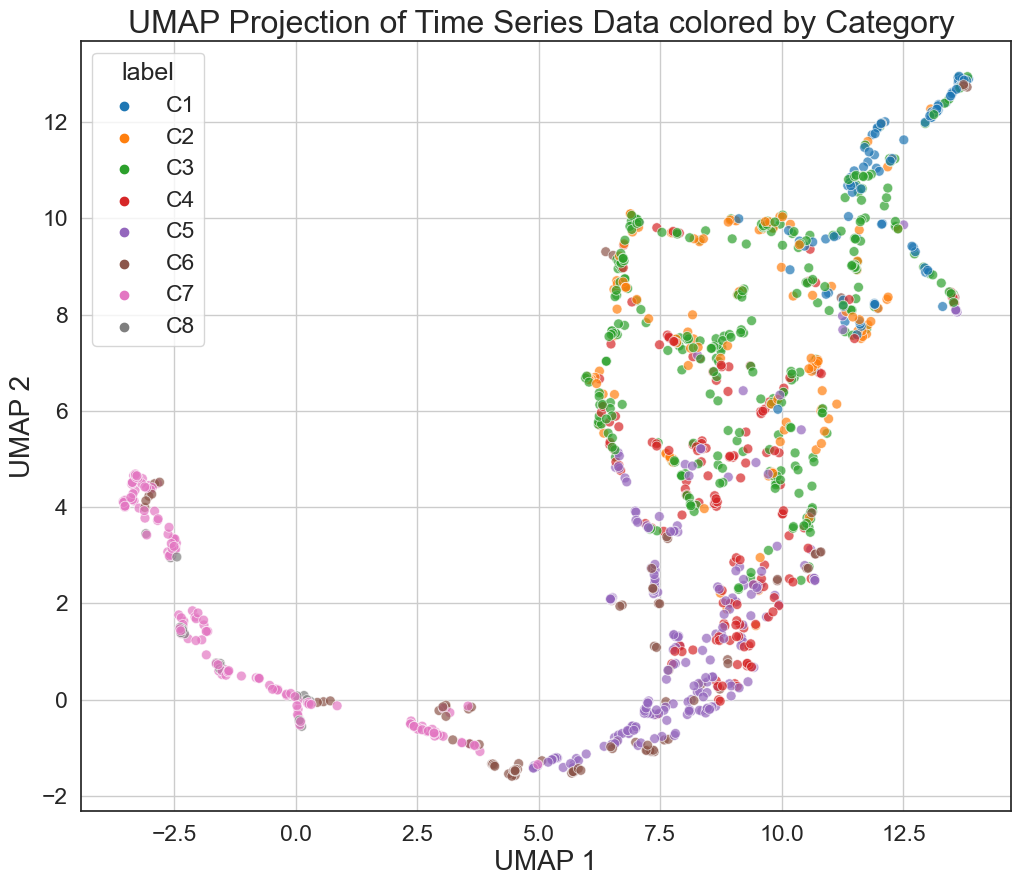

In [8]:
#Distribution of data points after dimensionality reduction
import seaborn as sns
# Create a DataFrame from embeddings and labels
df = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
order = ['C1','C2','C3','C4','C5','C6','C7','C8']
df['label'] = X_Emissions['Category']  
# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# Use Seaborn to create the scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2', hue='label', palette='tab10', edgecolor='w', s=50, alpha=0.7,hue_order=order)
plt.xlabel('UMAP 1', fontsize=20)
plt.ylabel('UMAP 2', fontsize=20)
plt.grid(True)
plt.title("UMAP Projection of Time Series Data colored by Category ",fontsize=23)
plt.show()

C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


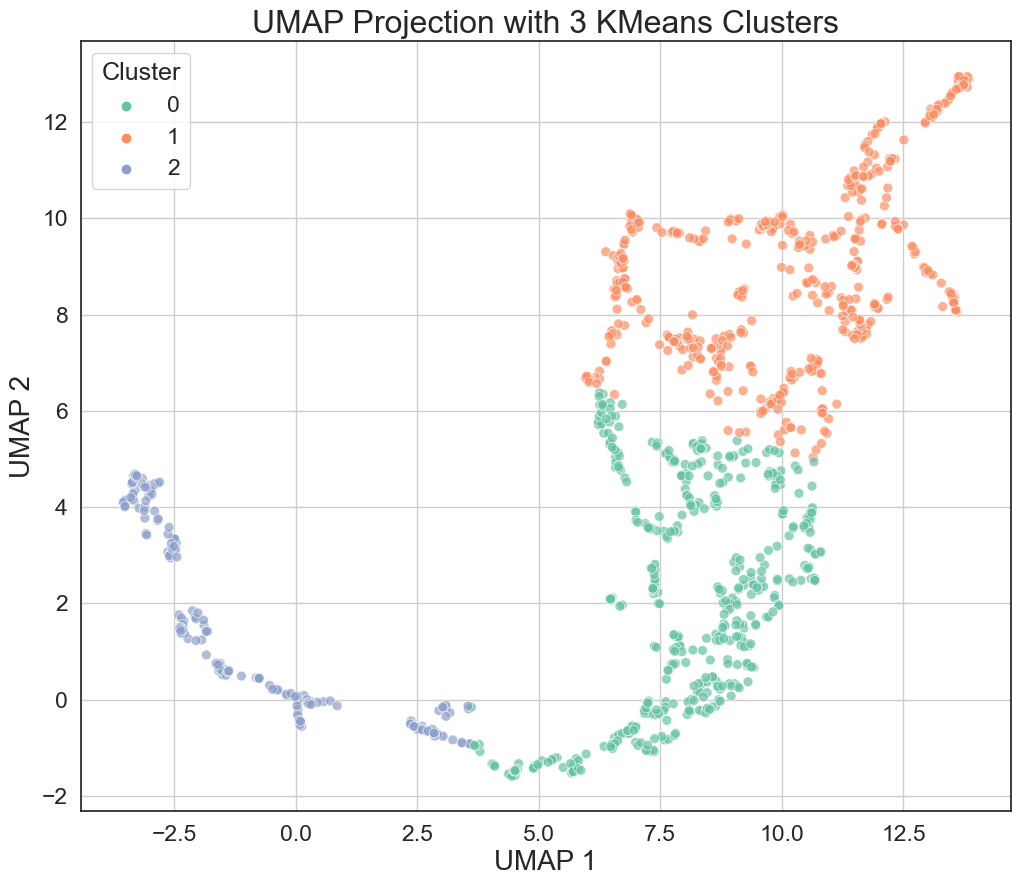

In [9]:
#Clustering based on Kyoto_Gases UMAP results
from sklearn.cluster import KMeans

# Define the number of clusters you want. For instance, if you want 3 clusters:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(embedding)

# The DataFrame now has an additional column named 'Cluster' with cluster labels.
# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2', hue='Cluster', palette='Set2', edgecolor='w', s=50, alpha=0.7)
plt.xlabel('UMAP 1', fontsize=20)
plt.ylabel('UMAP 2', fontsize=20)
plt.grid(True)
plt.title(f"UMAP Projection with {n_clusters} KMeans Clusters",fontsize=23)
plt.show()

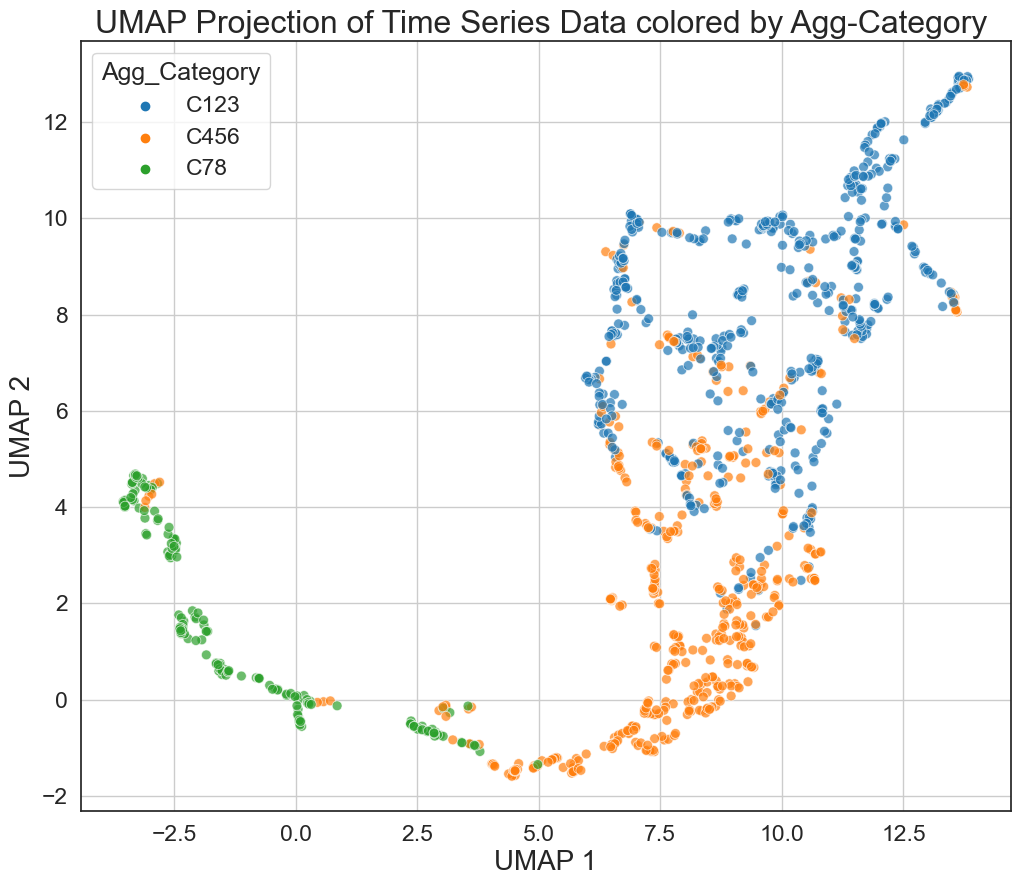

In [10]:
#Merge C1 C2 C3 into a class of C123, C4 C5 C6 into a class of C456, and C7 C8 into a class of C78 for analysis.
#Distribution of data points
mapping = {'C1':'C123','C2':'C123','C3':'C123','C4':'C456','C5':'C456','C6':'C456','C7':'C78','C8':'C78'}
order = ['C123','C456','C78']
df_class_merge = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_class_merge['Agg_Category']= X_Emissions['Category'].replace(mapping)
# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# Use Seaborn to create the scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_class_merge, x='UMAP 1', y='UMAP 2', hue='Agg_Category', palette='tab10', edgecolor='w', s=50, alpha=0.7,hue_order=order)
plt.xlabel('UMAP 1', fontsize=20)
plt.ylabel('UMAP 2', fontsize=20)
plt.grid(True)
plt.title("UMAP Projection of Time Series Data colored by Agg-Category ",fontsize=23)
plt.savefig('Agg-Category.pdf',format='pdf')
plt.show()

C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


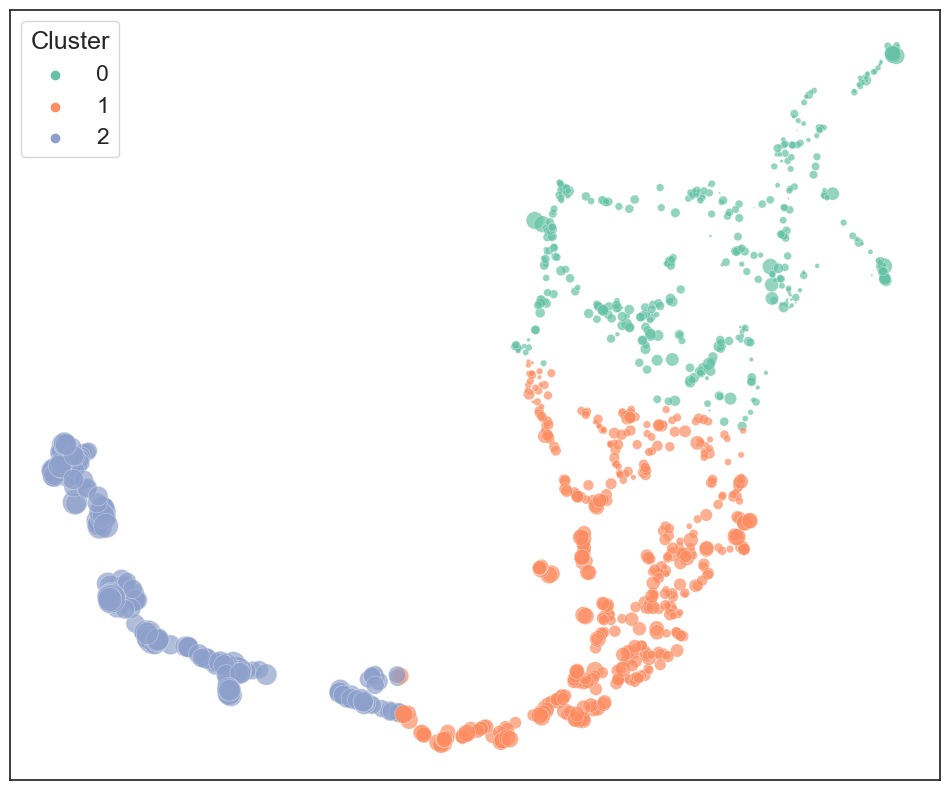

In [11]:
#Determine the size of the point based on Kyoto_Gases emissions
Emissions_Area = np.zeros(len(X_Emissions))
for i in range(len(X_Emissions)):
    for j in range(8):
        Emissions_Area[i] +=(X_Emissions_Sum[i][j] + X_Emissions_Sum[i][j+1]) * 5
Emissions_Area  = (Emissions_Area - Emissions_Area.mean()) / Emissions_Area.std(ddof=1)

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_class_merge['Cluster'] = kmeans.fit_predict(embedding)# The DataFrame now has an additional column named 'cluster' with cluster labels.
df_class_merge['Cluster'].replace({1:0,0:1},inplace=True)#The order of swapping tags makes the image more natural

# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_class_merge, x='UMAP 1', y='UMAP 2', hue='Cluster', palette='Set2', edgecolor='w', s=(Emissions_Area+1)*80, alpha=0.7)
ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
#plt.xlabel('UMAP 1', fontsize=20)
#plt.ylabel('UMAP 2', fontsize=20)
#plt.grid(True)
#plt.title(f"UMAP Projection with {n_clusters} KMeans Clusters",fontsize=23)
plt.savefig('UMAP.pdf',format='pdf')
plt.show()

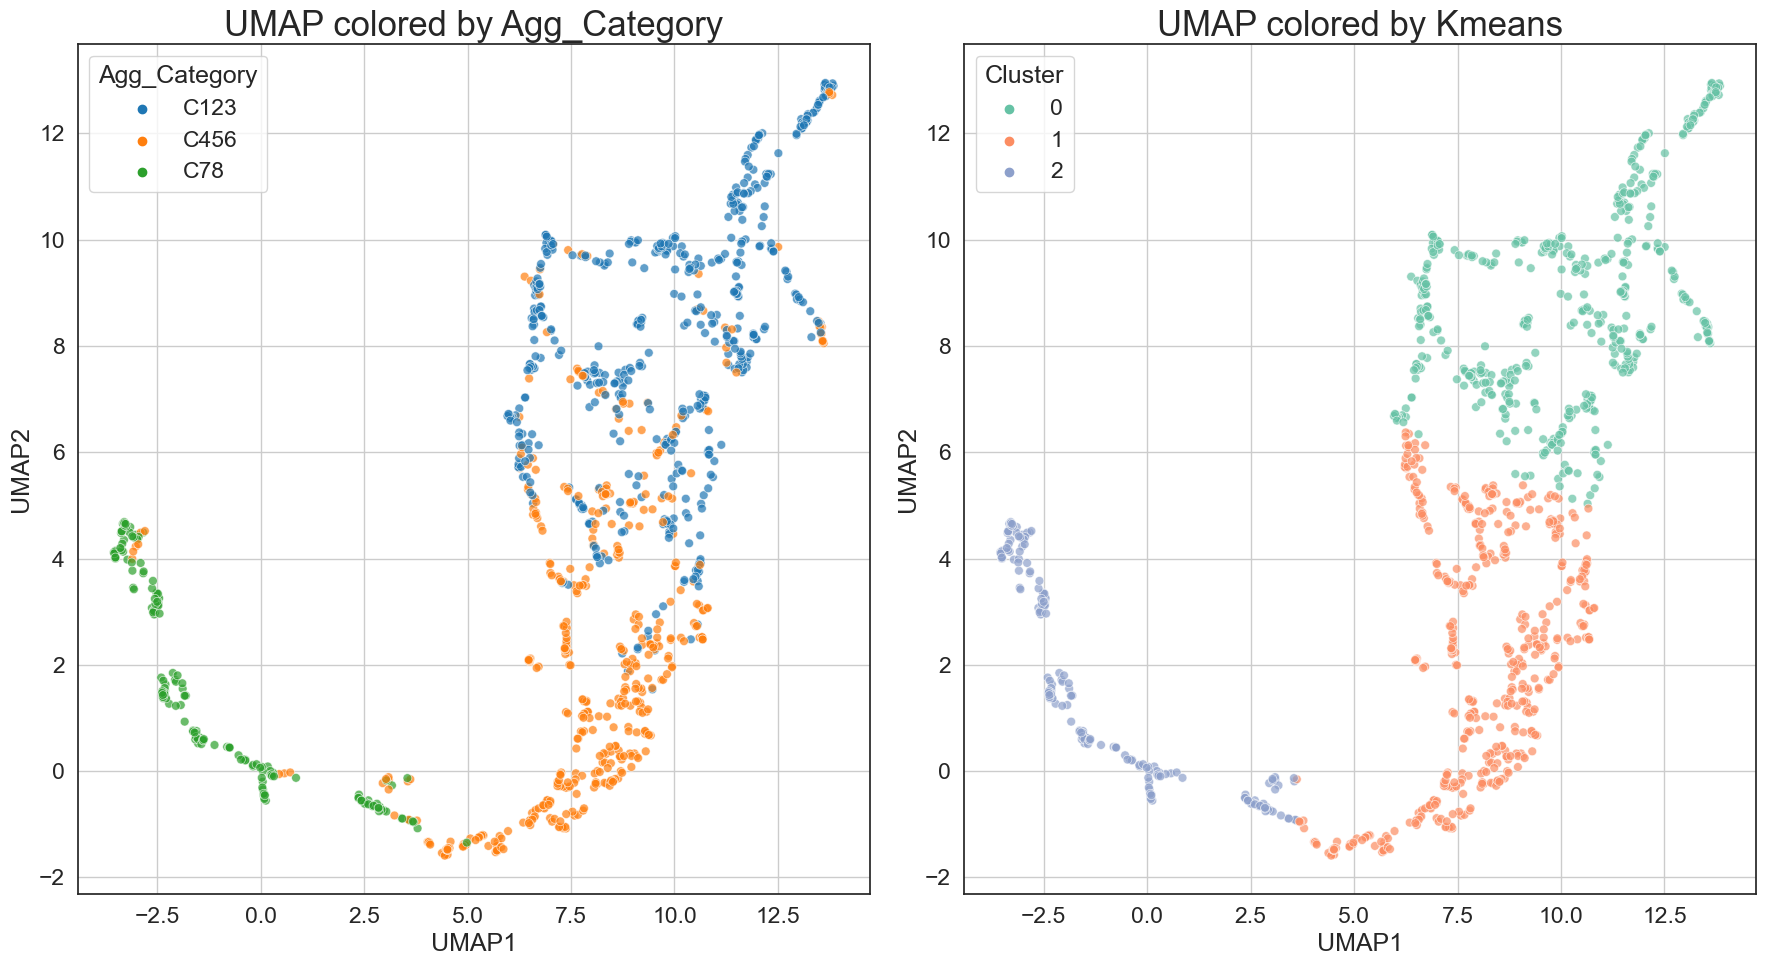

In [12]:
#True class distribution image and cluster distribution image
# Convert embeddings to DataFrame for visualization
df_embedding = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
mapping = {'C1':'C123','C2':'C123','C3':'C123','C4':'C456','C5':'C456','C6':'C456','C7':'C78','C8':'C78'}
order = ['C123','C456','C78']
df_embedding['Agg_Category'] = X_Emissions['Category'].replace(mapping)
df_embedding['Cluster'] = df_class_merge['Cluster']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot True Class distribution image
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Agg_Category', ax=axes[0], palette='tab10', alpha=0.7, s=40,hue_order=order)
axes[0].set_title('UMAP colored by Agg_Category',fontsize=25)
axes[0].grid()


# Plot Cluster distribution image
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Cluster', ax=axes[1], palette='Set2', alpha=0.7, s=40)
axes[1].set_title('UMAP colored by Kmeans',fontsize=25)
axes[1].grid()
plt.tight_layout()
plt.show()

C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\l1137\.conda\envs\Pytorch12.2\Lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


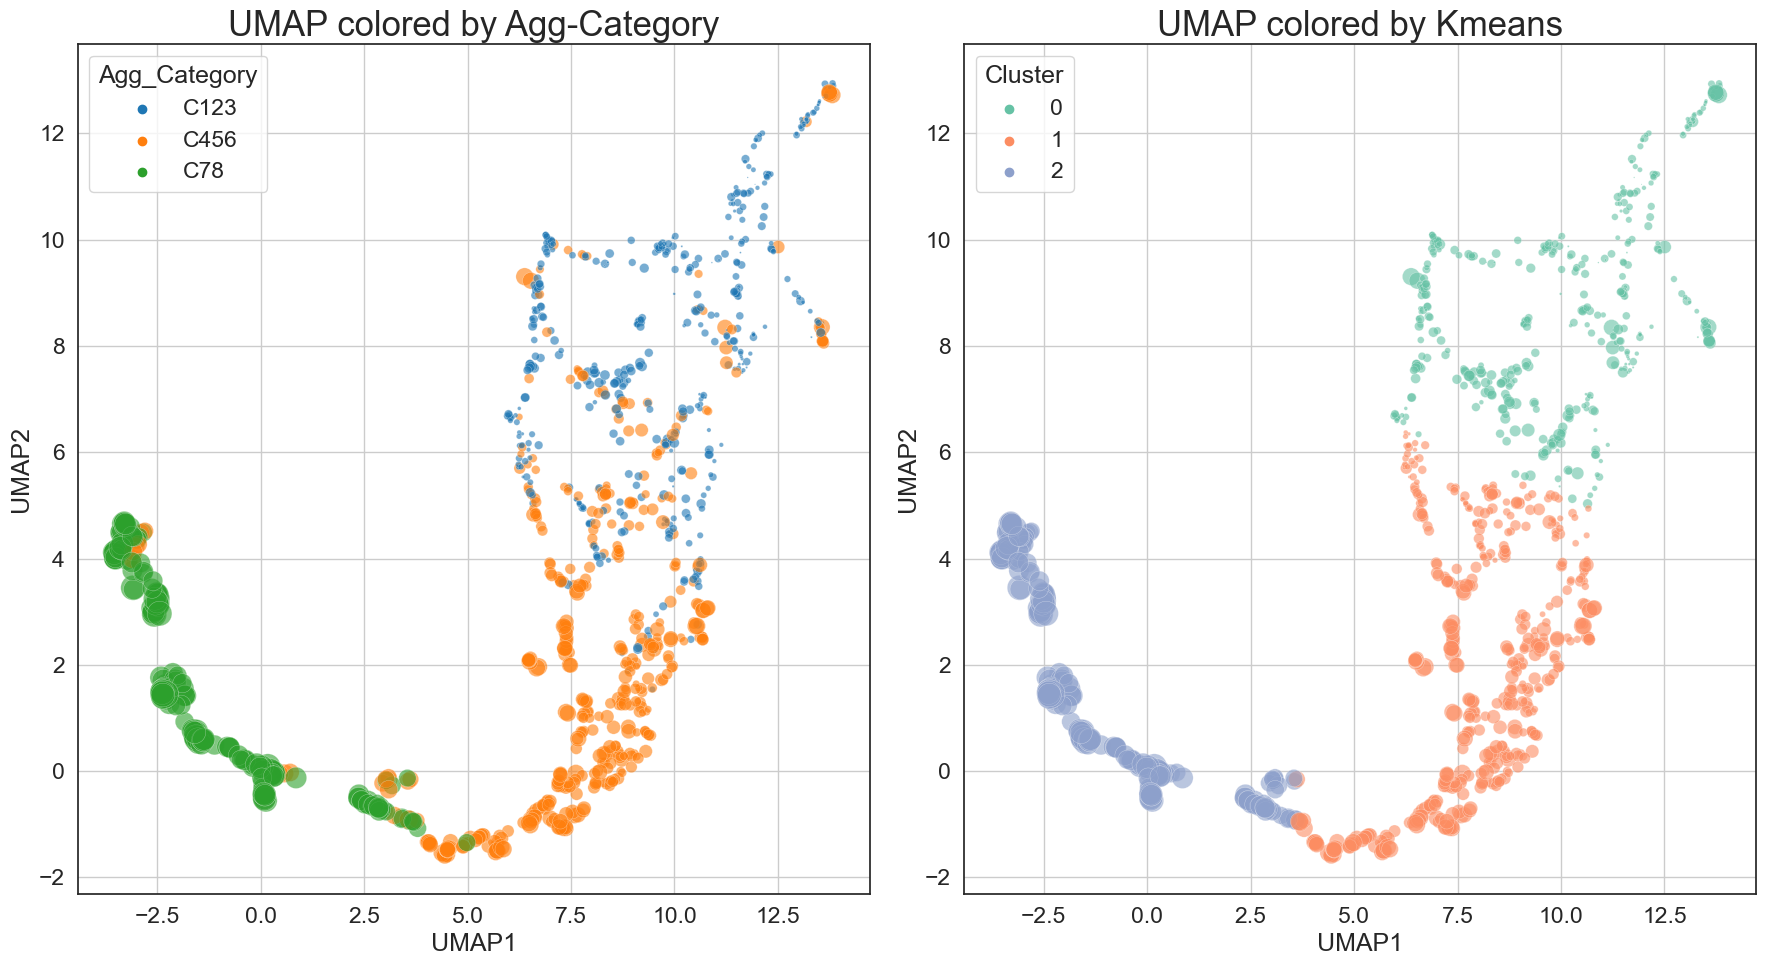

In [13]:
#Determine the size of the point based on Kyoto_Gases emissions
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
# True Agg-Category
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Agg_Category', ax=axes[0], palette='tab10', alpha=0.6, s= (Emissions_Area+1)*80,hue_order=order)
axes[0].set_title('UMAP colored by Agg-Category',fontsize=25)
axes[0].grid()

# Cluster distribution
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Cluster', ax=axes[1], palette='Set2', alpha=0.6, s= (Emissions_Area+1)*80)
axes[1].set_title('UMAP colored by Kmeans',fontsize=25)
axes[1].grid()
plt.tight_layout()
plt.savefig('Kmeans.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [14]:
#Plot emission curves for Kyoto_Gases under different classes and clusters.
X_Emissions['Agg_Category'] = df_class_merge['Agg_Category']
X_Emissions['Cluster'] = df_class_merge['Cluster']
long_df_Cluster = X_Emissions.drop(columns=['Category','Agg_Category']).melt(id_vars='Cluster', var_name='time', value_name='value')
long_df_Agg_Category = X_Emissions.drop(columns=['Category','Cluster']).melt(id_vars='Agg_Category', var_name='time', value_name='value')

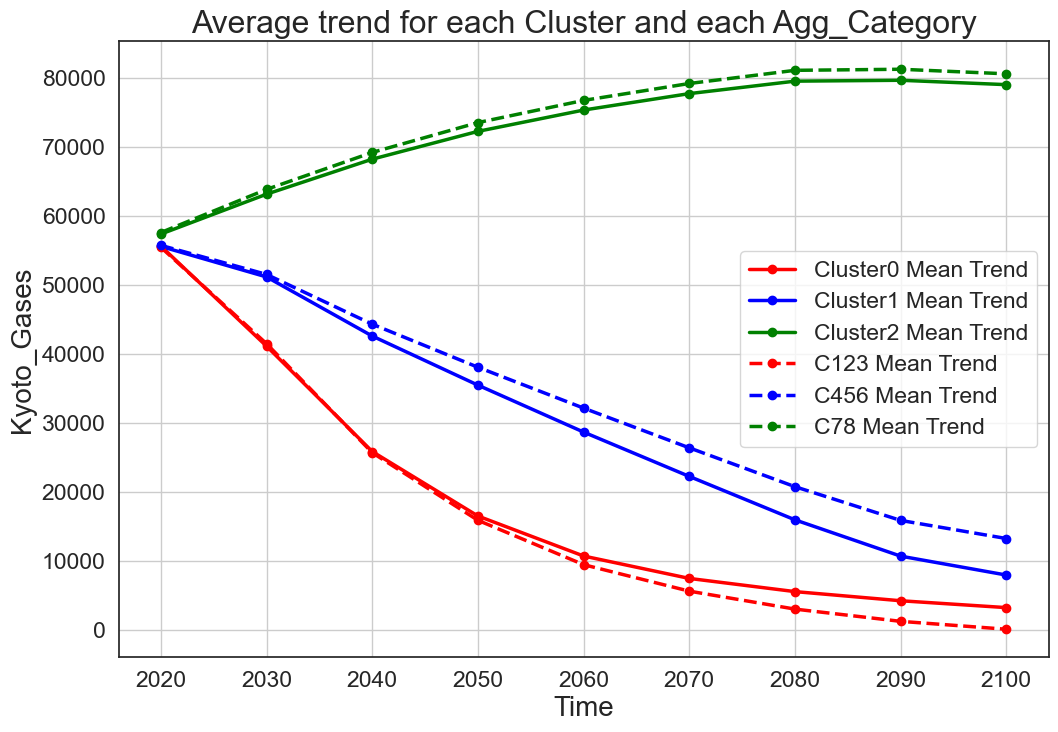

In [15]:
plt.figure(figsize=(12,8))
colors = ['red', 'blue', 'green']
for i in range(3):
    Category_data = long_df_Cluster[long_df_Cluster['Cluster'] == i]
    stats = Category_data.groupby('time').agg(mean=('value', 'mean')).reset_index()
    plt.plot(stats['time'], stats['mean'], color=colors[i], label=f'Cluster{i} Mean Trend',linestyle='-',marker='o')
Agg_Categories = ['C123','C456','C78']
for i,Agg_Category in enumerate(Agg_Categories) :
    Category_data = long_df_Agg_Category[long_df_Agg_Category['Agg_Category'] == Agg_Category]
    stats = Category_data.groupby('time').agg(mean=('value', 'mean')).reset_index()
    plt.plot(stats['time'], stats['mean'], color=colors[i], label=f'{Agg_Category} Mean Trend',linestyle='--',marker='o')

plt.xlabel('Time', fontsize=20)
plt.ylabel('Kyoto_Gases', fontsize=20)
plt.grid(True)
plt.title(f"Average trend for each Cluster and each Agg_Category",fontsize=23)
plt.savefig('Average trend for each Cluster and each Agg_Category.pdf',format='pdf',bbox_inches='tight')
plt.legend()
plt.show()

In [16]:
#Draw a Sankey diagram to observe the differences between clusters and true categories.
import plotly.graph_objects as go
# Create a DataFrame from Agg_Category and Cluster
df = pd.DataFrame({'Agg_Category': df_class_merge['Agg_Category'], 'Cluster': df_class_merge['Cluster']})

# Count the relationships
count_relationship = df.groupby(['Agg_Category', 'Cluster']).size().reset_index(name='count')

# Create lists for source, target, and value
source = count_relationship['Agg_Category'].astype(str)
target = count_relationship['Cluster'].astype(str)
value = count_relationship['count']

# Create a unique list of Agg_Category and Cluster labels
labels = pd.concat([source, target]).unique().tolist()

# Convert source and target labels to their respective indices
source_indices = source.apply(lambda x: labels.index(x))
target_indices = target.apply(lambda x: labels.index(x))

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=source_indices, target=target_indices, value=value)
))

fig.update_layout(title_text="Relationship between AggCategory and Kmeans-Cluster", font_size=10)
fig.show()